# Linear regression to non linear probabilistic neural network
In this post I will attempt to go over the steps between a simple linear regression
towards a non-linear probabilistic model built with a neural network.

This is particularly useful in case where the model noise changes with one of the model variables or is non-linear,
such as in those with heteroskedasticity.

Import stuff:

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

Let's generate some data with non-linearities that would pose some issues for a linear regression solution:

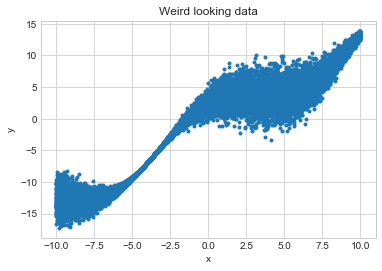

In [2]:
# amount of noise that is added is a function of x
n = 20000
x = np.random.uniform(-10, 10, size=n)
noise_std = np.sin(x * 0.4) + 1
y = (
    -0.5
    + 1.3 * x
    + 3 * np.cos(x * 0.5)
    + np.random.normal(loc=0, scale=noise_std)
)

x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

plt.plot(x, y, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Weird looking data")
plt.show()

## Linear regression approach
We can fit a linear regression model using tensorflow.
This model would have no hidden layers, so the output can only be a linear weighted sum of the input and a bias.
We optimise for the mean squared error, which is the standard loss function for linear regression.

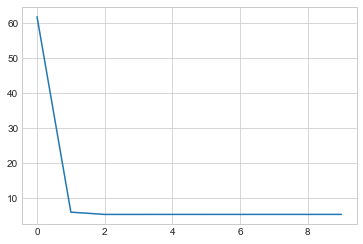

Final loss: 5.25


In [3]:
model_lin_reg = tf.keras.Sequential(
    [tf.keras.layers.Input(shape=(1,)), tf.keras.layers.Dense(1)]
)

model_lin_reg.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.mse,
    metrics=[tf.keras.losses.mse],
)

history = model_lin_reg.fit(x_train, y_train, epochs=10, verbose=0)
# Model has converged fine:
plt.plot(history.history["loss"])
plt.show()
print(f"""Final loss: {history.history["loss"][-1]:0.2f}""")

We'll define a couple helper functions to plot results:

In [4]:
def plot_results(x, y, y_est_mu, y_est_std=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, ".", label="y")
    plt.plot(x, y_est_mu, "-y", label="y_est_mu")
    if y_est_std is not None:
        plt.plot(x, y_est_mu + 2 * y_est_std, "-r", label="mu+2std")
        plt.plot(x, y_est_mu - 2 * y_est_std, "-r", label="mu-2std")
    plt.legend()
    plt.show()


def plot_model_results(model, x, y, tfp_model: bool = True):
    model.weights

    si = np.argsort(x)
    x = x[si]
    y = y[si]
    yhat = model(x)
    if tfp_model:
        y_est_mu = yhat.mean()
        y_est_std = yhat.stddev()
    else:
        y_est_mu = yhat
        y_est_std = np.nan
    plot_results(x, y, y_est_mu, y_est_std)



Plotting the fitted results from the linear regression shows it cannot capture the non-linearity of the data.
The standard deviation of the model residuals doesn't affect the converged regression coefficients so it is not plotted.

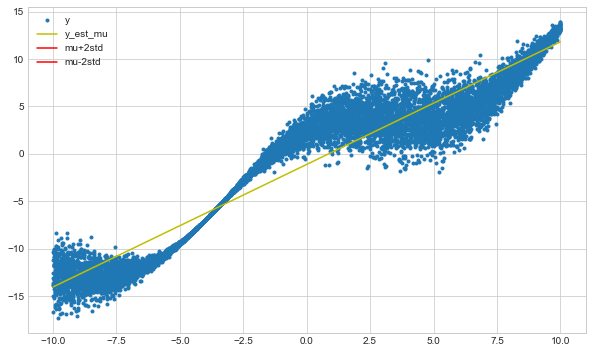

In [5]:
plot_model_results(model_lin_reg, x_train, y_train, tfp_model=False)

## Tensorflow probability
We can fit the same model above by maximising the likelihood of a normal distribution, where the mean is the estimates of the linear regression model.
This can be built within tensorflow probability.
The `DistributionLambda` is used to send the outputs of the `Dense` layer to the inputs of the distribution output layer.
The standard deviation is initially set to a static value.

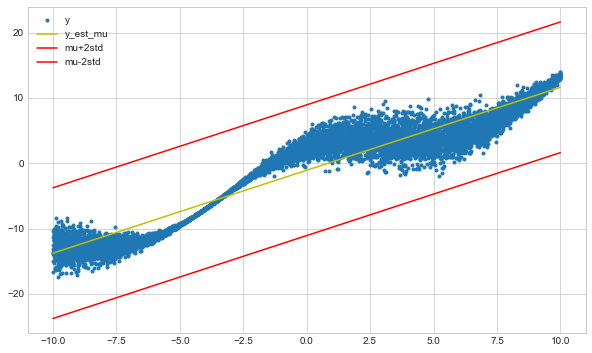

In [6]:
def negloglik(y, distr):
    return -distr.log_prob(y)


model_lin_reg_tfp = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(1),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t, scale=5,)
        ),
    ]
)

model_lin_reg_tfp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik
)

history = model_lin_reg_tfp.fit(x_train, y_train, epochs=20, verbose=0)
# plt.plot(history.history["loss"])
# plt.show()

plot_model_results(model_lin_reg_tfp, x_train, y_train, tfp_model=True)

## Fit linear regression with its standard deviation
In order to fit the optimal standard deviation of the linear regression model we do a couple of things.
We need the network to output two nodes, one for the mean as before and one for the standard deviation.
Using the `DistributionLambda` layer we feed the two parameters appropriately.
The softplus function is used to constrain the standard deviation to be positive.

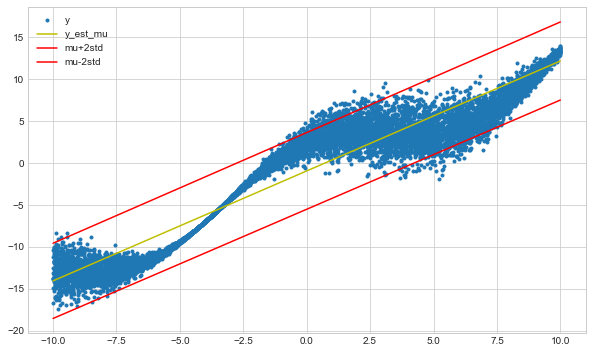

In [7]:
model_lin_reg_std_tfp = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[:, 0:1], scale=tf.math.softplus(t[:, 1:2])
            )
        ),
    ]
)

model_lin_reg_std_tfp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik
)

history = model_lin_reg_std_tfp.fit(x_train, y_train, epochs=50, verbose=0)
# plt.plot(history.history["loss"])
# plt.show()

plot_model_results(model_lin_reg_std_tfp, x_train, y_train, tfp_model=True)

The above plot shows that both the standard deviation and mean are tuned differently to before.
They both increase with the x variable.
However they are still not great fits for the data, as they don't capture the non-linearities.

## Neural network approach
To help fit the non-linearities we see in the relationship between x and y we can utilise a neural network.
This can simply be the same tensorflow model we designed about, but with a hidden layer with a non-linear activation function.
The sigmoid activation function was used as it is smooth and continuous, similar to our training data.

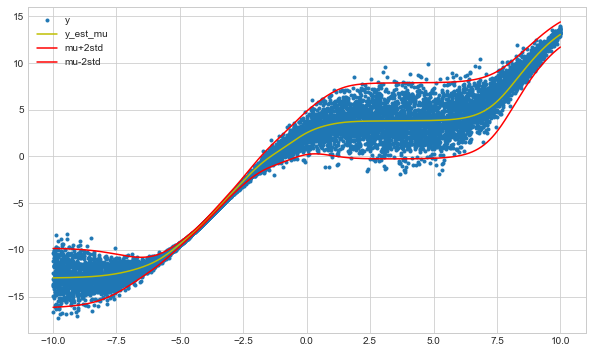

In [8]:
model_lin_reg_std_nn_tfp = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(10, activation="sigmoid"),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[:, 0:1], scale=tf.math.softplus(t[:, 1:2])
            )
        ),
    ]
)

model_lin_reg_std_nn_tfp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik
)

history = model_lin_reg_std_nn_tfp.fit(x_train, y_train, epochs=50, verbose=0)
# plt.plot(history.history["loss"])
# plt.show()

plot_model_results(model_lin_reg_std_nn_tfp, x_train, y_train, tfp_model=True)

The fitted means from the neural network model follow the data non-linearity much better than the linear regression case.

## Results
We run the models against the train and test sets. There is not a large performance change between the two on any model.
So overfitting doesn't seem to be an issue. we can see that the neural network model performs best on both the training and test sets.

In [9]:
results = pd.DataFrame(index=["Train", "Test"])

models = {
    "Linear regression": model_lin_reg_tfp,
    "Linear regression + std": model_lin_reg_std_tfp,
    "Neural network + std": model_lin_reg_std_nn_tfp,
}
for model in models:
    results[model] = [
        tf.reduce_mean(
            negloglik(y_train[:, tf.newaxis], models[model](x_train))
        ).numpy(),
        tf.reduce_mean(
            negloglik(y_test[:, tf.newaxis], models[model](x_test))
        ).numpy(),
    ]
results.transpose()

Train      Test
Linear regression        2.634172  2.634366
Linear regression + std  2.248769  2.250609
Neural network + std     1.110919  1.123843

## Extra little bit: Activation functions
Using the same network with different activation functions helps motivate our choice of sigmoid.
The following creates the same network with either a relu or softplus activation function.
Both of these act as sort of step functions, with the softplus being a smooth that relu.
First the results from relu network:

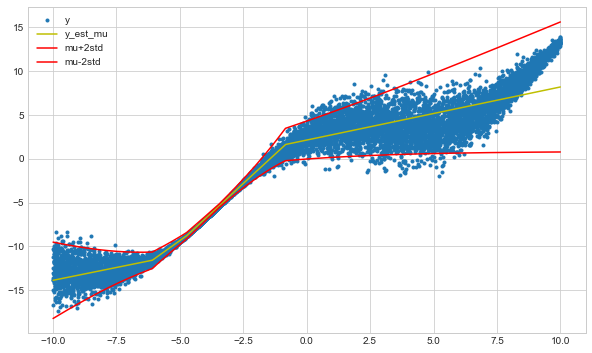

In [10]:
model_relu = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[:, 0:1], scale=tf.math.softplus(t[:, 1:2])
            )
        ),
    ]
)

model_relu.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik
)

history = model_relu.fit(x_train, y_train, epochs=50, verbose=0)
# plt.plot(history.history["loss"])
# plt.show()
plot_model_results(model_relu, x_train, y_train)

Then with softplus:

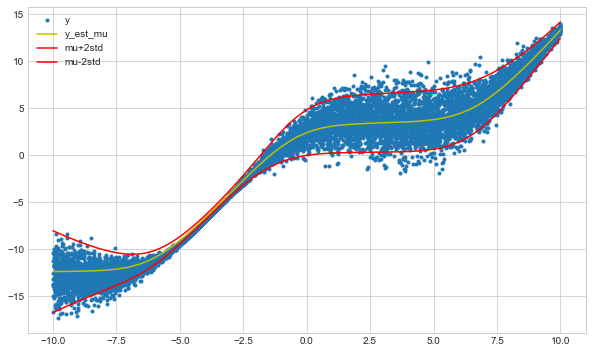

In [11]:
model_softplus = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(10, activation="softplus"),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[:, 0:1], scale=tf.math.softplus(t[:, 1:2])
            )
        ),
    ]
)

model_softplus.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik
)

history = model_softplus.fit(x_train, y_train, epochs=50, verbose=0)
# plt.plot(history.history["loss"])
# plt.show()
plot_model_results(model_softplus, x_train, y_train)

We can see that the sigmoid based network has the best performance:

In [12]:
results = pd.DataFrame(index=["Train", "Test"])

models = {
    "Linear regression": model_lin_reg_tfp,
    "Linear regression + std": model_lin_reg_std_tfp,
    "Neural network + std": model_lin_reg_std_nn_tfp,
    "Neural network relu": model_relu,
    "Neural network softplus": model_softplus,
}
for model in models:
    results[model] = [
        tf.reduce_mean(
            negloglik(y_train[:, tf.newaxis], models[model](x_train))
        ).numpy(),
        tf.reduce_mean(
            negloglik(y_test[:, tf.newaxis], models[model](x_test))
        ).numpy(),
    ]
results.transpose()

Train      Test
Linear regression        2.634172  2.634366
Linear regression + std  2.248769  2.250609
Neural network + std     1.110919  1.123843
Neural network relu      1.377944  1.386795
Neural network softplus  1.424538  1.431122